In [1]:
import os
import math
import sys
import warnings

import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageColor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torchvision
import torch
from torchvision import transforms as T
from torchmetrics.detection.map import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torch.utils.tensorboard import SummaryWriter

warnings.filterwarnings("ignore")

### Classes

In [3]:
anno_file = np.genfromtxt('../data/GTSDB/gt.txt',delimiter =';', dtype= None,encoding=None)

anno_dict = {}

for img_id, xmin, ymin, xmax, ymax, label in anno_file:
    if img_id in anno_dict:
        anno_dict[img_id]["boxes"] += [[xmin, ymin, xmax, ymax]]
        anno_dict[img_id]["labels"] += [label]
    else:
        anno_dict[img_id] = {}
        anno_dict[img_id]["boxes"] = [[xmin, ymin, xmax, ymax]]
        anno_dict[img_id]["labels"] = [label]

print(f"images: {len(anno_dict)}")
print(f"signs: {len(anno_file)}")

images: 741
signs: 1213


In [4]:
anno_dict["00001.ppm"]

{'boxes': [[983, 388, 1024, 432], [386, 494, 442, 552], [973, 335, 1031, 390]],
 'labels': [40, 38, 13]}

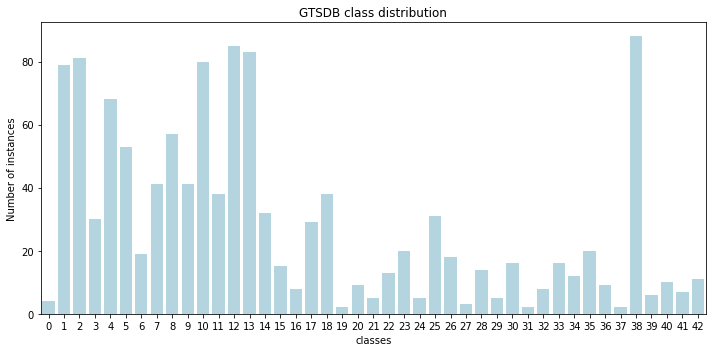

In [5]:
count_labels = {i: 0 for i in range(0,43)}
for _, target in anno_dict.items():
    for label in target['labels']:
        count_labels[label] += 1

fig = plt.figure(figsize=(10,5))
x, y = list(zip(*count_labels.items()))
sns.barplot(x=list(x), y=list(y), color="lightblue")
plt.title('GTSDB class distribution')
plt.xlabel('classes')
plt.ylabel('Number of instances')
plt.tight_layout()
plt.show()

In [6]:
classes = { 0:' Speed limit (20km/h)' ,  ###### Update this to start from 1
    1:' Speed limit (30km/h)' ,
    2:' Speed limit (50km/h)' ,
    3:' Speed limit (60km/h)' ,
    4:' Speed limit (70km/h)' ,
    5:' Speed limit (80km/h)' ,
    6:' End of speed limit (80km/h)' ,
    7:' Speed limit (100km/h)' ,
    8:' Speed limit (120km/h)' ,
    9:' No passing' ,
    10:' No passing veh over 3.5 tons' ,
    11:' Right-of-way at intersection' ,
    12:' Priority road' ,
    13:' Yield' ,
    14:' Stop' ,
    15:' No vehicles' ,
    16:' Veh > 3.5 tons prohibited' ,
    17:' No entry' ,
    18:' General caution' ,
    19:' Dangerous curve left' ,
    20:' Dangerous curve right' ,
    21:' Double curve' ,
    22:' Bumpy road' ,
    23:' Slippery road' ,
    24:' Road narrows on the right' ,
    25:' Road work' ,
    26:' Traffic signals' ,
    27:' Pedestrians' ,
    28:' Children crossing' ,
    29:' Bicycles crossing' ,
    30:' Beware of ice/snow' ,
    31:' Wild animals crossing' ,
    32:' End speed + passing limits' ,
    33:' Turn right ahead' ,
    34:' Turn left ahead' ,
    35:' Ahead only' ,
    36:' Go straight or right' ,
    37:' Go straight or left' ,
    38:' Keep right' ,
    39:' Keep left' ,
    40:' Roundabout mandatory' ,
    41:' End of no passing' ,
    42:' End no passing veh > 3.5 tons'
}

### Dataset

In [7]:
class GTSDB(torch.utils.data.Dataset):
    def __init__(self, image_dir, transforms=None, only_detect=False):
        self.image_dir = image_dir
        self.transforms = transforms
        self.only_detect = only_detect
        self.imgs = list(sorted(os.listdir(image_dir)))
 
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target = anno_dict.get(self.imgs[idx]) 

        if target is not None:
            target["boxes"] = torch.as_tensor(target['boxes'], dtype=torch.float32)

            target["labels"] = (
                torch.as_tensor(target["labels"], dtype=torch.int64)
                if not self.only_detect
                else torch.ones(len(target["labels"]), dtype=torch.int64)
            )

        else:
            target = {}
            target["boxes"] = torch.empty((0,4), dtype=torch.float32)
            target["labels"] = torch.empty((0), dtype=torch.int64)
 
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
import json

### Transforms

In [10]:
def get_transform(train):
    if train:
        return T.Compose(
            [
                T.ColorJitter(brightness=0.5, contrast=0.5),
                T.GaussianBlur(kernel_size=(3, 11), sigma=(0.1, 3)),
                T.ToTensor(),
            ]
        )
    else:
        return T.Compose([T.ToTensor()])

### Train

In [11]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler=None, writers=None):
    model.train()

    total_loss = []

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for idx, (images, targets) in enumerate(
        tqdm(data_loader, desc=f"Epoch [{epoch+1}]", position=0, leave=True)
    ):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # loss
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        total_loss += [losses.item()]

    for writer in writers:
        if writer is not None:
            writer.add_scalar("Loss/train", np.mean(total_loss), epoch)

    return np.mean(total_loss)

@torch.inference_mode()
def evaluate(model, data_loader, device, metric, epoch, writers=None):
    model.eval()

    for images, targets in tqdm(data_loader, desc="Evaluating score", position=0, leave=True):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.cuda.amp.autocast(enabled=False):
            detections = model(images, targets)

        metric.update(detections, targets)

    scores = metric.compute()
    metric.reset()


    model.train() # to get loss

    total_loss = []

    for images, targets in tqdm(data_loader, desc="Evaluating loss", position=0, leave=True):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        total_loss += [losses.item()]

    for writer in writers:
        if writer is not None:
            writer.add_scalar("Loss/val", np.mean(total_loss), epoch)
            writer.add_scalars("Score/val", scores, epoch)

    return np.mean(total_loss), scores


In [12]:
class Json_writer():
    def __init__(self, log_file, reset=True):
        if reset:
            self.data = {}
        else:
            with open(log_file) as f:
                self.data = json.load(f)
        
        self.log_file = log_file

    def add_scalar(self, tag, value, epoch):
        if torch.is_tensor(value):
            value = value.item()
        if tag in self.data:
            self.data[tag] += [value]
        else:
            self.data[tag] = [value]

    def add_scalars(self, tag, value_dict, epoch):
        if tag in self.data:
            for key, value in value_dict.items():
                if torch.is_tensor(value):
                    value = value.item()
                self.data[tag][key] += [value]
        else:
            self.data[tag] = {}
            for key, value in value_dict.items():
                if torch.is_tensor(value):
                    value = value.item()
                self.data[tag][key] = [value]

    def flush(self):
        with open(self.log_file, "w+") as f:
            json.dump(self.data, f, indent=6)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [14]:
only_detect = False
num_classes = 2 if only_detect else 44

dataset_trian = GTSDB("../data/GTSDB/train", transforms=get_transform(True), only_detect=only_detect)
dataset_val = GTSDB("../data/GTSDB/test", transforms=get_transform(False), only_detect=only_detect)

data_loader_train = torch.utils.data.DataLoader(
    dataset_trian,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    )

In [32]:

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 2

val_metric = MeanAveragePrecision()

train_losses = []
val_losses = []
val_scores = []

writers = [
    SummaryWriter(log_dir="logs/gtsdb/run_10"),
    Json_writer(log_file="logs/gtsdb/run_10.json"),
]

model = model.to(device)

for epoch in range(num_epochs):
    # train one epoch
    loss = train_one_epoch(model, optimizer, data_loader_train, device=device, epoch=epoch, writers=writers)
    train_losses += [loss]

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    loss, scores = evaluate(model, data_loader_test, device=device, metric=val_metric, epoch=epoch, writers=writers)
    val_losses += [loss]
    val_scores += [scores]

for writer in writers:
    writer.flush()


Evaluating loss: 100%|██████████| 150/150 [00:30<00:00,  4.91it/s]


#### Save model

In [45]:
torch.save(model, f'./saved_models/model{num_epochs}.pkl')
torch.save(model.state_dict(), f'./saved_models/model{num_epochs}.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, f'./saved_models/ckpt{num_epochs}.pth')

In [38]:
aa = Json_writer("logs/gtsdb/run_10.json", False)

In [39]:
aa.data

{'Loss/train': [0.681734551920866, 0.3152900227791785],
 'Loss/val': [0.2874873630469665, 0.24174932718703834],
 'Score/val': {'map': [0.020456338301301003, 0.06900028884410858],
  'map_50': [0.0474911630153656, 0.12687240540981293],
  'map_75': [0.011527971364557743, 0.06486724317073822],
  'map_small': [0.016452251002192497, 0.07605691254138947],
  'map_medium': [0.029511066153645515, 0.08424893021583557],
  'map_large': [0.0, 0.20173126459121704],
  'mar_1': [0.051589783281087875, 0.13627073168754578],
  'mar_10': [0.08361048996448517, 0.1818751096725464],
  'mar_100': [0.08361048996448517, 0.1818751096725464],
  'mar_small': [0.08644244074821472, 0.22667033970355988],
  'mar_medium': [0.10100023448467255, 0.20194761455059052],
  'mar_large': [0.0, 0.4520000219345093],
  'map_per_class': [-1.0, -1.0],
  'mar_100_per_class': [-1.0, -1.0]}}

In [40]:
train_losses = aa.data['Loss/train']
val_losses = aa.data['Loss/val']
val_scores = aa.data['Score/val']

In [43]:
val_scores

{'map': [0.020456338301301003, 0.06900028884410858],
 'map_50': [0.0474911630153656, 0.12687240540981293],
 'map_75': [0.011527971364557743, 0.06486724317073822],
 'map_small': [0.016452251002192497, 0.07605691254138947],
 'map_medium': [0.029511066153645515, 0.08424893021583557],
 'map_large': [0.0, 0.20173126459121704],
 'mar_1': [0.051589783281087875, 0.13627073168754578],
 'mar_10': [0.08361048996448517, 0.1818751096725464],
 'mar_100': [0.08361048996448517, 0.1818751096725464],
 'mar_small': [0.08644244074821472, 0.22667033970355988],
 'mar_medium': [0.10100023448467255, 0.20194761455059052],
 'mar_large': [0.0, 0.4520000219345093],
 'map_per_class': [-1.0, -1.0],
 'mar_100_per_class': [-1.0, -1.0]}

### Plot

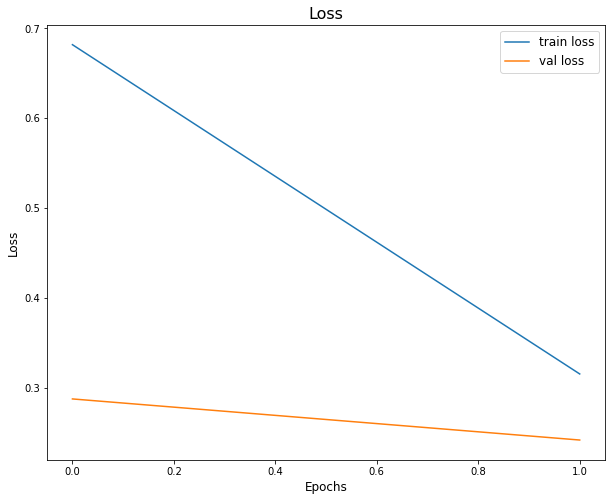

In [41]:
epochs = range(num_epochs)
fig = plt.figure(figsize=(10,8))
plt.plot(epochs, train_losses, label="train loss")
plt.plot(epochs, val_losses, label="val loss")
plt.xlabel("Epochs", fontdict={'size': 12})
plt.ylabel("Loss", fontdict={'size': 12})
plt.title("Loss", fontdict={'size': 16})
plt.legend(prop={'size': 12})
plt.show()

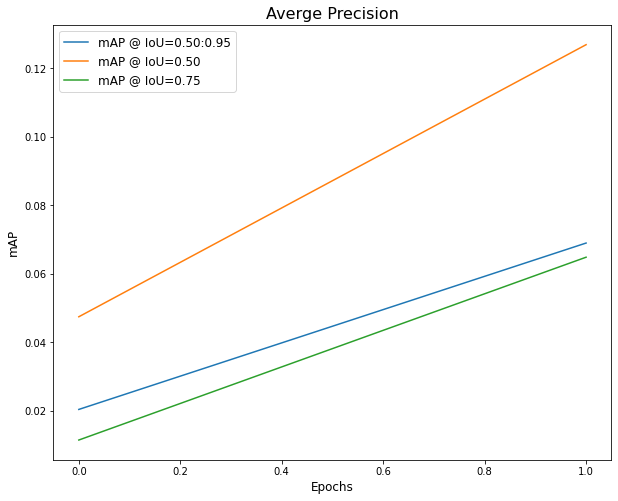

In [44]:
val_map = val_scores['map'] #[elm['map'] for elm in val_scores]
val_map50 = val_scores['map_50'] #[elm['map_50'] for elm in val_scores]
val_map75 = val_scores['map_75'] #[elm['map_75'] for elm in val_scores]

score_metric = "AP" if only_detect else "mAP"

fig = plt.figure(figsize=(10,8))
plt.plot(epochs, val_map, label=f"{score_metric} @ IoU=0.50:0.95")
plt.plot(epochs, val_map50, label=f"{score_metric} @ IoU=0.50")
plt.plot(epochs, val_map75, label=f"{score_metric} @ IoU=0.75")
plt.xlabel("Epochs", fontdict={'size': 12})
plt.ylabel(score_metric, fontdict={'size': 12})
plt.title("Averge Precision", fontdict={'size': 16})
plt.legend(prop={'size': 12})
plt.show()

In [48]:
final_score = val_scores[-1]
final_score

{'map': tensor(0.1693),
 'map_50': tensor(0.2665),
 'map_75': tensor(0.2054),
 'map_small': tensor(0.2230),
 'map_medium': tensor(0.2109),
 'map_large': tensor(0.6081),
 'mar_1': tensor(0.3298),
 'mar_10': tensor(0.3990),
 'mar_100': tensor(0.3990),
 'mar_small': tensor(0.4512),
 'mar_medium': tensor(0.4255),
 'mar_large': tensor(0.8200),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

### Inference

In [16]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str=""):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_height = (1 + 2 * 0.05) * font.getsize(display_str)[1]

  if top > display_str_height:
    text_bottom = top
  else:
    text_bottom = top + display_str_height

  text_width, text_height = font.getsize(display_str)
  margin = np.ceil(0.05 * text_height)
  draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
  draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)



def draw_boxes(image, boxes, labels, scores, keep, max_boxes=10, min_score=0.01, classes=None):
  """ returns PIL image with boxes """
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  im_height, im_width = image.shape[1:]
  image_pil = T.ToPILImage()(image)

  for i in range(min(len(boxes), max_boxes)):
    if scores[i] >= min_score and i in keep:
      xmin, ymin, xmax, ymax = tuple(boxes[i])
      xmin, ymin, xmax, ymax = xmin / im_width, ymin / im_height, xmax / im_width, ymax / im_height
      label = classes[labels[i].item()] if classes is not None else labels[i].item()
      display_str = f"{label}: {int(100 * scores[i])}%"
      color = colors[hash(labels[i]) % len(colors)]
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str=display_str)
  return image_pil

In [17]:
def predict(img, model):
    model.eval()

    with torch.no_grad():
        pred = model([img.to(device)])[0]

    keep = torchvision.ops.nms(pred['boxes'] , pred['scores'], 0.1)
    return pred, keep

def predict_and_display(img, model, classes=None):
    pred, keep = predict(img, model)
    return draw_boxes(img.cpu(), pred['boxes'].cpu(), pred['labels'].cpu(), pred['scores'].cpu(), keep.cpu(), classes=classes)

In [10]:
model = torch.load("saved_models/model100.pkl")

In [18]:
def get_iou(box1, box2):
    """
    computes intersection over union
    boxes on form: [xmin, ymin, xmax, ymax]
    """
    bb1 = {
        'x1':box1[0], 
        'y1':box1[1],
        'x2':box1[2],
        'y2':box1[3],
        }
    bb2 = {
        'x1':box2[0], 
        'y1':box2[1],
        'x2':box2[2],
        'y2':box2[3],
        }

    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [19]:
only_detect = False
num_classes = 2 if only_detect else 44

dataset_val = GTSDB("../data/GTSDB/test", transforms=get_transform(False), only_detect=only_detect)

data_loader_test = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    )

In [24]:
model.eval()

total = []
hits = []
miss = []
backgrounds = []
class_err = []
double = []

do_class = False

for imgs, targets in data_loader_test:
    with torch.no_grad():
        preds = model([img.to(device) for img in imgs])

    targets = [{k: v.cpu() for k, v in t.items()} for t in targets]
    preds = [{k: v.cpu() for k, v in t.items()} for t in preds]
    
    for pred, target in zip(preds, targets):
        total += target['labels']

        if len(target['boxes']) == 0:
            backgrounds += pred['labels']

        elif len(pred['boxes']) == 0:
            miss += target['labels']

        else:
            chosen = {i: False for i in range(len(target['boxes']))}
            for j, box_p in enumerate(pred['boxes']):
                cand = []
                for i, box_t in enumerate(target['boxes']):
                    iou = get_iou(box_p, box_t)
                    cand += [(i, iou)]

                cand = sorted(cand, key=lambda x: -x[1])
                found = False

                if len(cand) > 0:
                    i, iou = cand[0]
                    if iou >= 0.5:
                        found = True
                        if chosen[i]:
                            double += [target['labels'][i]]
                        else:
                            if do_class:
                                if pred['labels'][j] == target['labels'][i]:
                                    chosen[i] = True
                                else:
                                    class_err += [(target['labels'][i], pred['labels'][j])]
                            else:
                                chosen[i] = True
                    else:
                        backgrounds += [pred['labels'][j]]
                else:
                    backgrounds += [pred['labels'][j]]
            for i, b in chosen.items():
                if b:
                    hits += [target['labels'][i]]
                else:
                    miss += [target['labels'][i]]

In [25]:
len(total), len(hits), len(miss), len(backgrounds), len(double), len(class_err)

(361, 356, 5, 672, 1566, 0)

In [26]:
[classes[m.item()] for m in miss]

[' Yield',
 ' General caution',
 ' General caution',
 ' Traffic signals',
 ' Traffic signals']

In [1]:
predict_and_display(dataset_val[11][0], model, classes)

NameError: name 'predict_and_display' is not defined